In [44]:
.libPaths(c(.libPaths(),'/usr/local/lib/R/site-library/'))
.libPaths(c(.libPaths(),'/usr/lib/R/library/'))
.libPaths(c(.libPaths(),'/home/david/R/x86_64-pc-linux-gnu-library/3.4'))
library(ggplot2)
library(ggrepel)
library(cluster)
library(reshape2)
source('~/projects/assembly17/run-ni-stv/other_avr_functions.R')
source('~/projects/assembly17/run-ni-stv/stv_fix.R')
library(circlize)
library(dplyr)
library(corrplot)
library(formattable)

In [94]:
set.seed(93510)
votes <- read.csv('~/projects/assembly17/run-ni-stv/recog_2017_votes_home.csv', header=FALSE, stringsAsFactors=FALSE)
tra_votes <- as.data.frame(t(votes[,2:ncol(votes)]))
candidates <- votes[,1]
voters <- read.csv('~/projects/assembly17/run-ni-stv/recog_2017_names_home.csv',header=FALSE)$V1
random_order <- sample(seq(nrow(tra_votes)))
tra_votes <- tra_votes[random_order, ]
names(tra_votes) <- candidates
row.names(tra_votes) <- paste('b',seq(nrow(tra_votes)),sep='')
voters <- voters[random_order]

tra_votes[is.na(tra_votes)] <- 6

tra_votes_inv <- 6 - tra_votes #1-6 becomes 5-0

6 candidates on ballot
7 votes received


cand,R1,R2,R3,R4,R5,R6,elected
Dinner,2,2,2,3,E,E,TRUE
Bowling,2,2,2,2,2,4,TRUE
Avoca,2,2,2,2,2,,FALSE
Board,1,1,1,,,,FALSE
Escape,0,0,,,,,FALSE
Laser,0,,,,,,FALSE


In [5]:
do_ensemble_stv(read_votes_from_csv('~/projects/assembly17/run-ni-stv/recog_2017_votes_home.csv'), 2, 1000)

6 candidates on ballot

24 votes received



,candidate,elected_pct
2,Dinner,100.0
3,Board,33.9
1,Avoca,33.3
4,Bowling,32.8


### Headlines

In [3]:
cat(sprintf('Turnout was %.0f%% (%i/32)\n', nrow(tra_votes)*100/32, nrow(tra_votes)))

Turnout was 22% (7/32)


In [107]:
#The vote in full:
tra_votes[order(tra_votes$Dinner,tra_votes$Avoca),]

,Dinner,Bowling,Avoca,Board,Escape,Laser
b13,1,3,2,4,5,6
b7,1,6,3,2,6,6
b4,1,6,4,2,3,5
b16,1,2,5,4,6,3
b20,1,2,5,4,6,3
b18,1,3,6,5,2,4
b1,2,5,1,3,6,4
b9,2,6,1,5,4,3
b15,2,6,1,3,5,4
b10,2,5,4,1,3,6


In [21]:
first_preferences <- apply(tra_votes,2,function(r) sum(r==1, na.rm=T))
sort(first_preferences, decreasing = TRUE)

Dinner Bowling   Avoca   Board  Escape   Laser 
      2       2       2       1       0       0

Assign 5 points for first preference, 4 for second...0 for sixth, and sum:

In [22]:
weighted_votes <- apply(tra_votes_inv, 2, function(r) sum(r, na.rm=T))
sort(weighted_votes, decreasing = TRUE)

Dinner Bowling   Avoca   Board   Laser  Escape 
     26      19      17      17      14      12

Or weight main preferences more heavily:

In [23]:
convert_prefs_to_weight <- function(r) {
    sum(r==1, na.rm=T) + sum(r==2, na.rm=T)*0.5 + sum(r==3, na.rm=T)*0.25 + sum(r==4, na.rm=T)*0.125 + sum(r==5, na.rm=T)*0.0625
}
more_weighted_votes <- apply(tra_votes,2,function(r) convert_prefs_to_weight(r))
more_weighted_votes

Dinner Bowling   Avoca   Board  Escape   Laser 
 3.7500  2.8750  2.5000  2.0625  1.1250  1.2500

        candidates First prefs Weighted prefs More weighted prefs
Dinner      Dinner   0.2857143      0.2476190          0.27649770
Bowling    Bowling   0.2857143      0.1809524          0.21198157
Avoca        Avoca   0.2857143      0.1619048          0.18433180
Board        Board   0.1428571      0.1619048          0.15207373
Escape      Escape   0.0000000      0.1142857          0.08294931
Laser        Laser   0.0000000      0.1333333          0.09216590
[1] Dinner  Bowling Avoca   Board   Laser   Escape 
Levels: Avoca Board Bowling Dinner Escape Laser


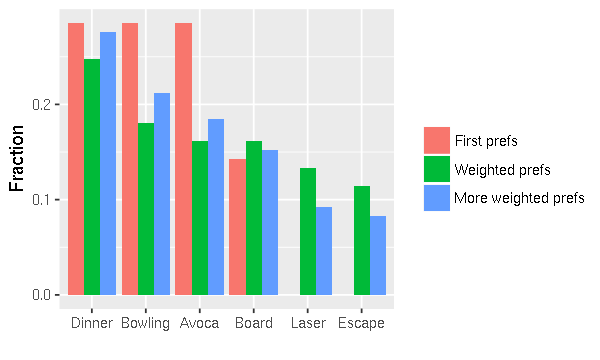

In [37]:
options(repr.plot.width=5, repr.plot.height=3)

first_preferences_norm <- first_preferences / sum(first_preferences)
weighted_votes_norm <- weighted_votes / sum(weighted_votes)
more_weighted_votes_norm <- more_weighted_votes / sum(more_weighted_votes)
plot_df <- data.frame(candidates=names(weighted_votes_norm), 
                      `First prefs`=first_preferences_norm, 
                      `Weighted prefs`=weighted_votes_norm,
                      `More weighted prefs`=more_weighted_votes_norm,
                     check.names=FALSE)
print(plot_df)
cands_by_wv <- plot_df$candidates[order(-plot_df[,'Weighted prefs'],-plot_df[,'More weighted prefs'])]
print(cands_by_wv)
plot_df <- melt(plot_df, id.vars='candidates')
names(plot_df) <- c('candidates','method','Fraction')
plot_df$candidates <- factor(plot_df$candidates, levels=cands_by_wv)

ggplot(plot_df) + geom_col(aes(candidates,Fraction,fill=method),position='dodge') +
    labs(x='',fill='')

In [19]:
check_which_prefs <- function(votes, winners) {
    apply(votes[,winners],1,min)
}
for (opt2 in c('Bowling','Avoca','Board')) {
    cat(sprintf('With Dinner and %s, %.0f%% can choose pref 1 or 2\n',
               opt2, mean(check_which_prefs(tra_votes,c('Dinner',opt2)) <= 2)*100))
}

With Dinner and Bowling, 100% can choose pref 1 or 2
With Dinner and Avoca, 71% can choose pref 1 or 2
With Dinner and Board, 86% can choose pref 1 or 2


### Transfers

We can look at what actually happened in the count shown on the whiteboard:

In [26]:
transfers <- readRDS('~/Documents/sample_transfer_matrix.rds')
transfers

,Avoca,Dinner,Board,Laser,Bowling,Escape
Board,0,1,NA,NA,0,NA
Avoca,NA,1,NA,NA,0,NA
Dinner,NA,NA,NA,NA,1,NA


Or better, we can measure what every candidate would have transferred to if given the opportunity, by looking at the next preference in each ballot. This is a bit inexact due to the different options available to transfer to within each ballot. Here I'm ignoring the 5 to 6 transfers (where there is no other option left), and counting all other transfers as  a success (1) for the candidate chosen next in the ballot, and a failure (0) for all other options that were available but not transferred to. Then group by 'from' and 'to'.

In [171]:
#tra_votes
transfers_full <- data.frame()
# for (b in seq(nrow(tra_votes))) {
#     for (i in seq(5)) {
#         from <- names(tra_votes)[which(tra_votes[b,]==i)]
#         left <- names(tra_votes)[which(tra_votes[b,]>i)]
#         to <- names(tra_votes)[which(tra_votes[b,]==i+1)]
#         if (length(left) > 1) {
#             #cat(b,i,from,'transferring, choice of',left,', went to',to,'\n')
#             for (potential in left) {
#                 val <- ifelse(potential==to, 1, 0)
#                 transfers_full <- rbind(transfers_full,
#                                        data.frame(Candidate=from,Target=potential,val=val))
#             }
#         }
        
#     }
# }
# transfers_full <- transfers_full %>% group_by(Candidate,Target) %>% summarise(fraction_transferred=mean(val))

#Alternative: weight 1-2 transfer twice as much as 2-3, etc. Ignore 5-6.
#  And also count transfers displaced by more than 1 preference, but weighted less. 
#  So a 1-3 is worth half a 1-2, and the same as a 2-3. Pretty arbitrary.
for (b in seq(nrow(tra_votes))) {
    for (i in seq(4)) {
        downweight_factor <- 1 / 2**(i-1)
        from <- names(tra_votes)[which(tra_votes[b,]==i)]
        if (length(from) == 0) break
            
        left <- names(tra_votes)[which(tra_votes[b,]>i)]
        #to <- names(tra_votes)[which(tra_votes[b,]==i+1)]
        #if (length(to) == 0) to <- 'Dropped'
            
        transfer_scores <- 1 / 2**(tra_votes[b,][which(tra_votes[b,]>i)]-i-1)
        for (potential in left) {
            #val <- ifelse(potential==to, 1, 0) * downweight_factor
            val <- transfer_scores[, potential] * downweight_factor
            transfers_full <- rbind(transfers_full,
                                   data.frame(Candidate=from, Target=potential,
                                             val=val, possible=downweight_factor))
            if (from == 'Avoca') {
                cat(b,i,from,potential,downweight_factor,val,'\n')
            }
        }
    }
}
print(subset(transfers_full, Candidate=='Avoca'))
print(subset(transfers_full, Candidate=='Avoca') %>% group_by(Target) %>% summarise(sum(val),sum(possible)))
transfers_full <- transfers_full %>% group_by(Candidate,Target) %>% summarise(fraction_transferred=sum(val)/sum(possible))

#normalise: as method is rough, we get outgoing fractions not summing to 1
out_fractions <- transfers_full %>% group_by(Candidate) %>% summarise(tot_from=sum(fraction_transferred))
transfers_full <- merge(transfers_full, out_fractions, by='Candidate')
transfers_full$fraction_transferred <- transfers_full$fraction_transferred / transfers_full$tot_from

print(subset(transfers_full, Candidate=='Laser') %>% group_by(Target) %>% summarise(mean(fraction_transferred)))

1 1 Avoca Dinner 1 1 
1 1 Avoca Bowling 1 0.125 
1 1 Avoca Board 1 0.5 
1 1 Avoca Escape 1 0.0625 
1 1 Avoca Laser 1 0.25 
4 4 Avoca Bowling 0.125 0.0625 
4 4 Avoca Laser 0.125 0.125 
5 1 Avoca Dinner 1 0.0625 
5 1 Avoca Bowling 1 1 
5 1 Avoca Board 1 0.5 
5 1 Avoca Escape 1 0.125 
5 1 Avoca Laser 1 0.25 
6 1 Avoca Dinner 1 0.0625 
6 1 Avoca Bowling 1 1 
6 1 Avoca Board 1 0.125 
6 1 Avoca Escape 1 0.25 
6 1 Avoca Laser 1 0.5 
7 3 Avoca Bowling 0.25 0.0625 
7 3 Avoca Escape 0.25 0.0625 
7 3 Avoca Laser 0.25 0.0625 
9 1 Avoca Dinner 1 1 
9 1 Avoca Bowling 1 0.0625 
9 1 Avoca Board 1 0.125 
9 1 Avoca Escape 1 0.25 
9 1 Avoca Laser 1 0.5 
10 4 Avoca Bowling 0.125 0.125 
10 4 Avoca Laser 0.125 0.0625 
12 1 Avoca Dinner 1 0.25 
12 1 Avoca Bowling 1 1 
12 1 Avoca Board 1 0.5 
12 1 Avoca Escape 1 0.125 
12 1 Avoca Laser 1 0.0625 
13 2 Avoca Bowling 0.5 0.5 
13 2 Avoca Board 0.5 0.25 
13 2 Avoca Escape 0.5 0.125 
13 2 Avoca Laser 0.5 0.0625 
14 4 Avoca Bowling 0.125 0.125 
14 4 Avoca Laser 0.12

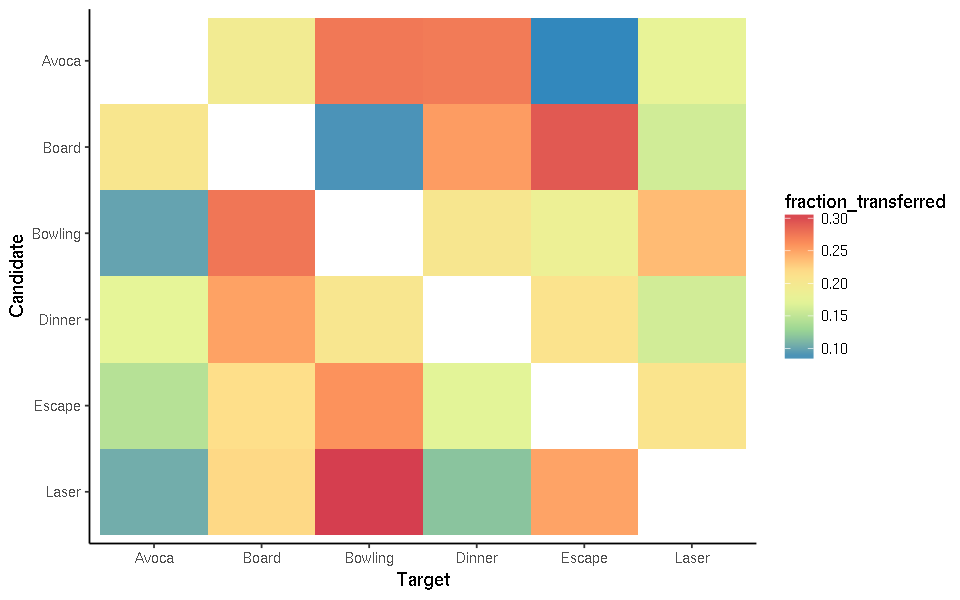

In [172]:
options(repr.plot.width=8, repr.plot.height=5)
transfers_full$Candidate <- factor(transfers_full$Candidate, 
                                   levels=rev(c('Avoca','Board','Bowling','Dinner','Escape','Laser')))
transfers_full$Target <- factor(transfers_full$Target, 
                                levels=c('Avoca','Board','Bowling','Dinner','Escape','Laser'))
ggplot(transfers_full,aes(Target,Candidate)) + geom_tile(aes(fill=fraction_transferred)) +
    scale_fill_distiller(palette='Spectral',direction=-1) + theme_classic()

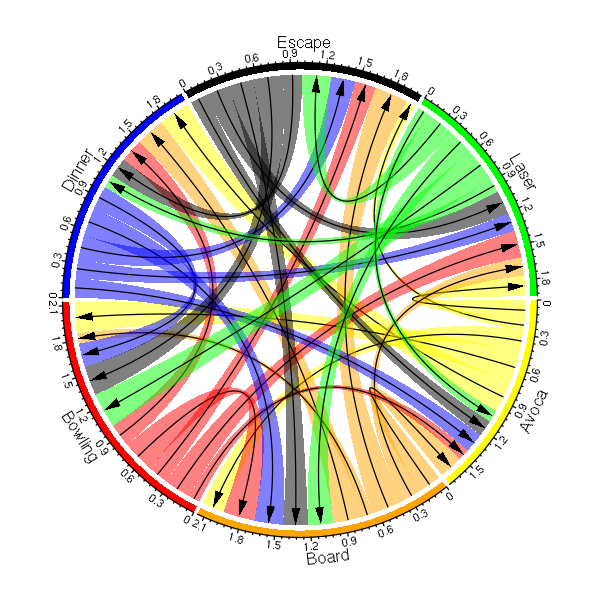

In [173]:
options(repr.plot.width=5, repr.plot.height=5)
grid.col <- c(Avoca='yellow',Dinner='blue',Laser='green',Board='orange',Escape='black',Bowling='red')
chordDiagram(transfers_full, directional=1, direction.type = 'arrows', grid.col=grid.col)

Plain old correlations show WHAT**

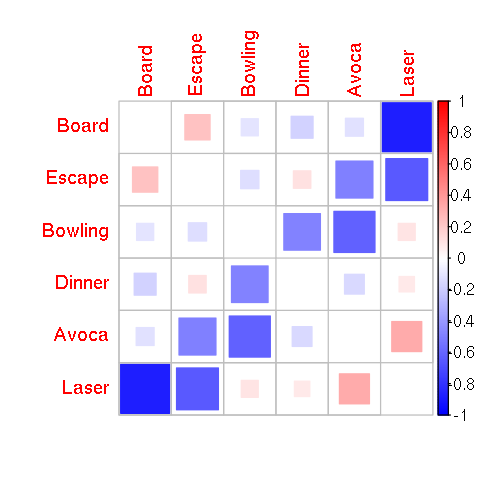

In [58]:
options(repr.plot.width=4, repr.plot.height=4)
corrplot(cor(tra_votes),method='square',diag=FALSE,order='FPC',
        col=colorRampPalette(c("blue","white","red"))(200))

,Dinner,Bowling,Avoca,Board,Escape,Laser
b1,50.000,6.25,100.000,25.00,3.125,12.5
b2,25.000,50.00,3.125,6.25,12.500,100.0
b3,3.125,12.50,6.250,100.00,50.000,25.0


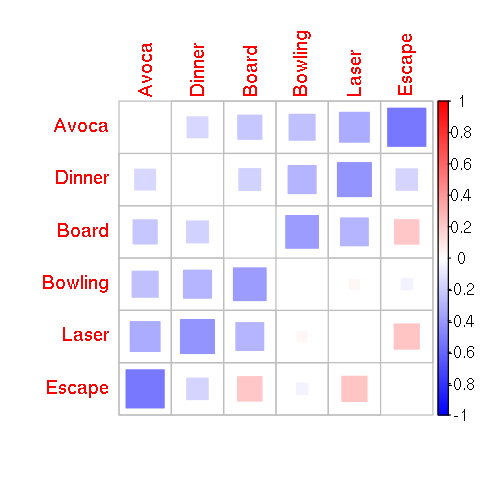

In [151]:
options(repr.plot.width=4, repr.plot.height=4)

#Or using more weighted form:
convert_pref_to_strength <- function(r, wt_scale) {
    return(100 / wt_scale**(r-1))
}
tra_votes_strengths <- apply(tra_votes,2,convert_pref_to_strength,2)
head(tra_votes_strengths,3)
corrplot(cor(tra_votes_strengths),method='square',diag=FALSE,order='FPC',
        col=colorRampPalette(c("blue","white","red"))(200))

### Clustering

,Dinner,Bowling,Avoca,Board,Escape,Laser
1,3.615385,2.153846,5.076923,3.692308,3.615385,2.846154
2,2.636364,4.727273,2.181818,2.545455,4.636364,4.818182


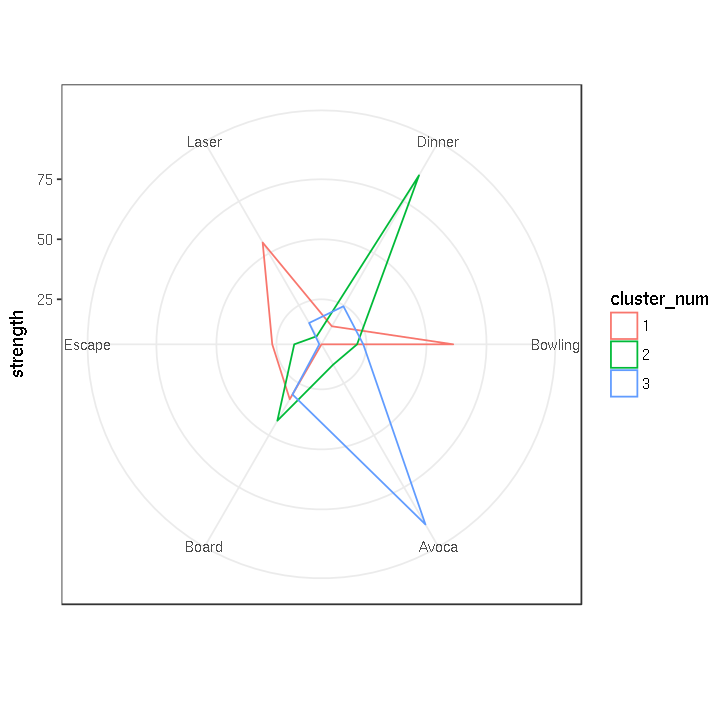

In [152]:
options(repr.plot.width=6, repr.plot.height=6)

cluster_centroids <- melt(kmeans(tra_votes_strengths, 3, nstart=20)$centers)
names(cluster_centroids) <- c('cluster_num','candidate','strength')
cluster_centroids$cluster_num <- factor(cluster_centroids$cluster_num)
ggplot(cluster_centroids) + 
    geom_polygon(aes(candidate,strength,colour=cluster_num,group=cluster_num),fill=NA) +
    coord_polar() +
    theme_bw() + labs(x='')
#TODO reorder levels to match order of cluster 1
kmeans(tra_votes,2,nstart=20)$centers

In [ ]:
#If ran STV on each of the clusters, winner should be as expected from above

Clustering in terms of the candidates:

In [104]:
print(votes)
kmeans(votes[,2:8],2)

       V1 V2 V3 V4 V5 V6 V7 V8
1  Dinner  2  2  4  1  1  2  4
2 Bowling  5  5  1  3  2  6  1
3   Avoca  1  4  5  6  5  1  3
4   Board  3  1  2  5  4  5  5
5  Escape  6  3  3  2  6  4  6
6   Laser  4  6  6  4  3  3  2


K-means clustering with 2 clusters of sizes 3, 3

Cluster means:
        V2 V3 V4       V5 V6 V7 V8
1 2.333333  4  5 3.666667  3  2  3
2 4.666667  3  2 3.333333  4  5  4

Clustering vector:
[1] 1 2 1 2 2 1

Within cluster sum of squares by cluster:
[1] 39.33333 43.33333
 (between_SS / total_SS =  32.5 %)

Available components:

[1] "cluster"      "centers"      "totss"        "withinss"     "tot.withinss"
[6] "betweenss"    "size"         "iter"         "ifault"      

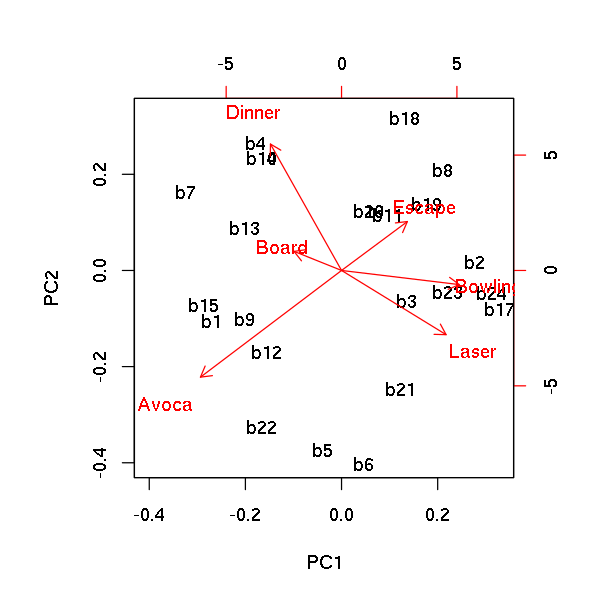

In [95]:
#Dim reduction? Can do for ballots, placing each on a 2d grid.
#  e.g. to left means 'how Avoca' you are, up means 'how Laser/Bowling'
options(repr.plot.width=5, repr.plot.height=5)
biplot(prcomp(tra_votes_inv))

In [42]:
paste(colnames(tra_votes)[as.numeric(tra_votes[1,])],collapse=',')

[1] "Avoca,Bowling,Laser,Escape,Board,Dinner"

   Dinner Bowling Avoca Board Escape Laser
b3      6       4     5     1      2     3
[1] "Board,Escape,Laser,Bowling,Avoca,Dinner"


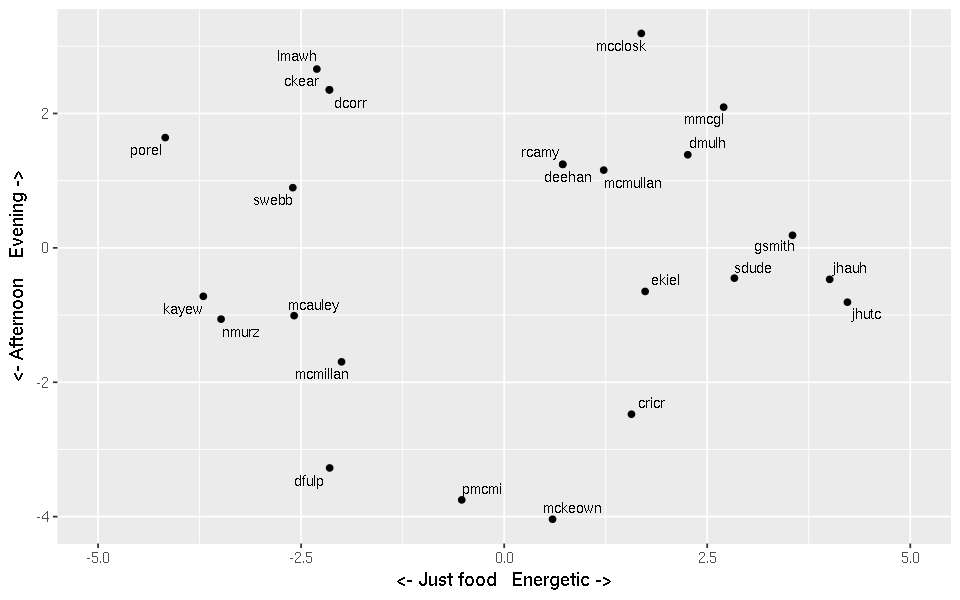

In [110]:
#TODO or can plot nicely with ggplot and label ballots by first pref, and describe axis meanings
options(repr.plot.width=8, repr.plot.height=5)
fp_labels <- as.character(apply(tra_votes, 1, function(r) names(tra_votes)[which(r==1)]))
fp_labels <- paste0(row.names(tra_votes),' (',fp_labels,')')

get_ballots <- function(row, candidates) {
    ballot <- c()
    for (i in seq(6)) {
        if (length(which(row==i)) > 0) {
            ballot <- c(ballot, candidates[which(row==i)])
        } else {
            break
        }
    }
    paste(ballot,collapse=',')
}
print(tra_votes[3,])
    
full_labels <- as.character(apply(tra_votes, 1, get_ballots, names(tra_votes)))
print(full_labels[3])    
    
ggplot(data.frame(prcomp(tra_votes_inv)$x)) + 
    geom_point(aes(PC1,PC2)) + 
    geom_text_repel(aes(PC1,PC2,label=voters),size=3) +
    labs(x='<- Just food   Energetic ->', y='<- Afternoon    Evening ->') +
    xlim(-5,5) 
#TODO hide tick values
#TODO interactive? http://ouzor.github.io/blog/2014/11/21/interactive-visualizations.html

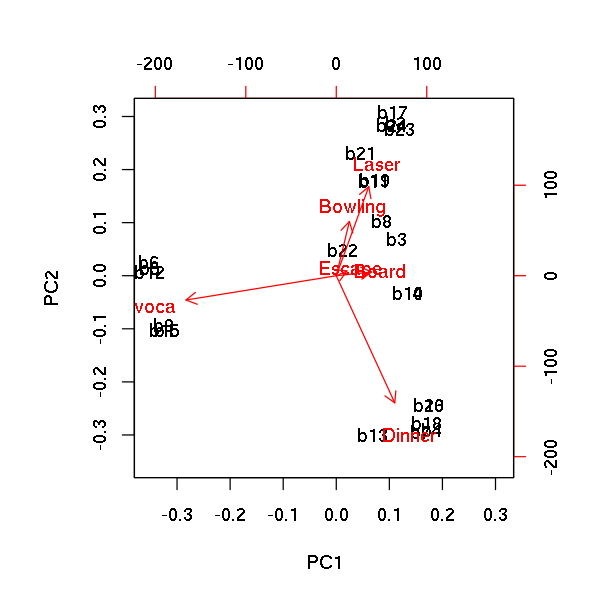

In [138]:
options(repr.plot.width=5, repr.plot.height=5)
biplot(prcomp(tra_votes_strengths),choices=c(1,2))

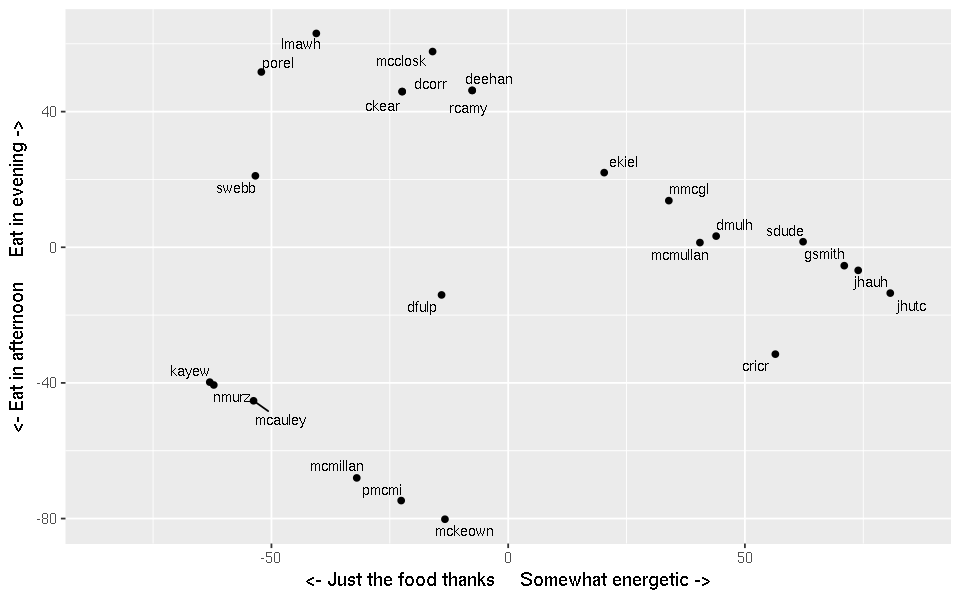

In [102]:
options(repr.plot.width=8, repr.plot.height=5)
ggplot(data.frame(prcomp(tra_votes_strengths)$x)) + 
    geom_point(aes(PC1,PC2)) +
    geom_text_repel(aes(PC1,PC2,label=voters),size=3) +
    labs(y='<- Eat in afternoon     Eat in evening ->', x='<- Just the food thanks     Somewhat energetic ->') +
    xlim(-85,85) #+ theme(base_size = 16)